# Problem Statement

The aim is to enhance user experience by implementing a personalized product ranking system. Your task is to develop an algorithm or model that can generate accurate and relevant product rankings for individual users. The ranking system should consider factors such as user preferences, past interactions, product popularity, and user similarity. It should be able to predict the most suitable products for a user based on their unique characteristics and preferences.

You are not provided with a specific dataset for this challenge. Instead, you are expected to design and implement a solution that simulates user interactions and generates personalized rankings. You can define user profiles, product categories, and interaction patterns within your solution.

To evaluate the effectiveness of your solution, you should define appropriate metrics for measuring the accuracy and relevance of the rankings. You should also provide a report explaining your approach, describing the algorithms or techniques used, and discussing the strengths and limitations of your solution.


# Steps involved building ML model
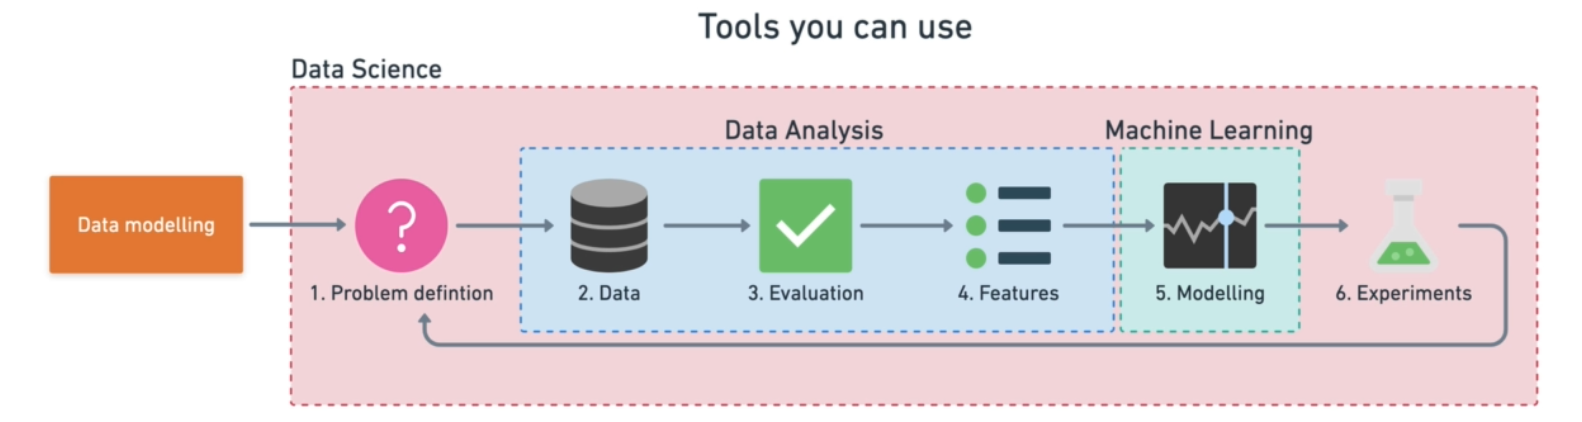

# 1. DATA

## About the datasets
- ```Reviews Dataset``` for users with no interaction or anonymous users.
- ```Product Dataset``` for users with product interaction

### Reviews Dataset Explained
- ```id``` : Unique identity number to identify each unique review given by the user to a particular product in the dataset
- ```brand``` : Name of the brand of the product to which user has given review and rating
- ```categories``` : Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products, health care products and many more.
- ```manufacturer``` : Name of the manufacturer of the product
- ```name``` : Name of the product to which user has added review or rating
- ```reviews_date``` : Date on which the review has been added by the user
- ```reviews_didPurchase``` : Whether a particular user has purchased the product or not
- ```reviews_doRecommend``` : Whether a particular user has recommended the product or not
- ```reviews_rating``` : Rating given by the user to a particular product
- ```reviews_text``` : Review given by the user to a particular product
- ```reviews_title``` : The title of the review given by the user to a particular product
- ```reviews_userCity``` : The residing city of the user
- ```reviews_userProvince``` : The residing province of the user
- ```reviews_username``` : The unique identification for individual user in the dataset
- ```user_sentiment``` : The overall sentiment of the user for a particular product (Positive or Negative)

### Recommendation Systems
- Based on item review (positive or negative review)
- Based on item similarity (similar title with or without price and discount filter, will be implemented in future)

# Building Recommendation System based on Item Review

## Importing Libraries

In [1]:
# import data analysis libraries
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])

# import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize
from collections import Counter
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE

# Import pickle to save and load the model
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# importing libraries for XGBoost classifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics.pairwise import pairwise_distances

from pprint import pprint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:
# Reading Dataset
df = pd.read_csv("./reviews_dataset.csv", engine='python')

## Data Analysis

In [5]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5.0,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,TRUE,NaN,5.0,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,TRUE,NaN,5.0,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,FALSE,FALSE,1.0,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,FALSE,FALSE,1.0,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [6]:
df.shape

(20638, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20638 entries, 0 to 20637
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    20638 non-null  object 
 1   brand                 20638 non-null  object 
 2   categories            20638 non-null  object 
 3   manufacturer          20638 non-null  object 
 4   name                  20638 non-null  object 
 5   reviews_date          20611 non-null  object 
 6   reviews_didPurchase   13055 non-null  object 
 7   reviews_doRecommend   19162 non-null  object 
 8   reviews_rating        20637 non-null  float64
 9   reviews_text          20637 non-null  object 
 10  reviews_title         20501 non-null  object 
 11  reviews_userCity      1450 non-null   object 
 12  reviews_userProvince  55 non-null     object 
 13  reviews_username      20590 non-null  object 
 14  user_sentiment        20637 non-null  object 
dtypes: float64(1), obje

In [8]:
df.shape

(20638, 15)

In [9]:
# checking for null values in dataset
null_values_count = df[df.columns[df.isna().any()]].isna().sum()
null_values_count

reviews_date               27
reviews_didPurchase      7583
reviews_doRecommend      1476
reviews_rating              1
reviews_text                1
reviews_title             137
reviews_userCity        19188
reviews_userProvince    20583
reviews_username           48
user_sentiment              1
dtype: int64

29000+ values are null, so such columns would not contribute in building our model. Hence dropping such columns.

In [10]:
df.drop(columns=['reviews_userProvince','reviews_userCity','reviews_didPurchase', 'reviews_doRecommend'], inplace=True)

In [11]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5.0,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5.0,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5.0,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1.0,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1.0,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [12]:
df.shape

(20638, 11)

In [13]:
df = df.dropna(subset=['reviews_title'])

In [14]:
fill_values = {'user_sentiment': 'Positive'}
df.fillna(value=fill_values, inplace=True)

<ipython-input-14-74564006715f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5.0,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5.0,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5.0,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1.0,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1.0,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


## Visualizing

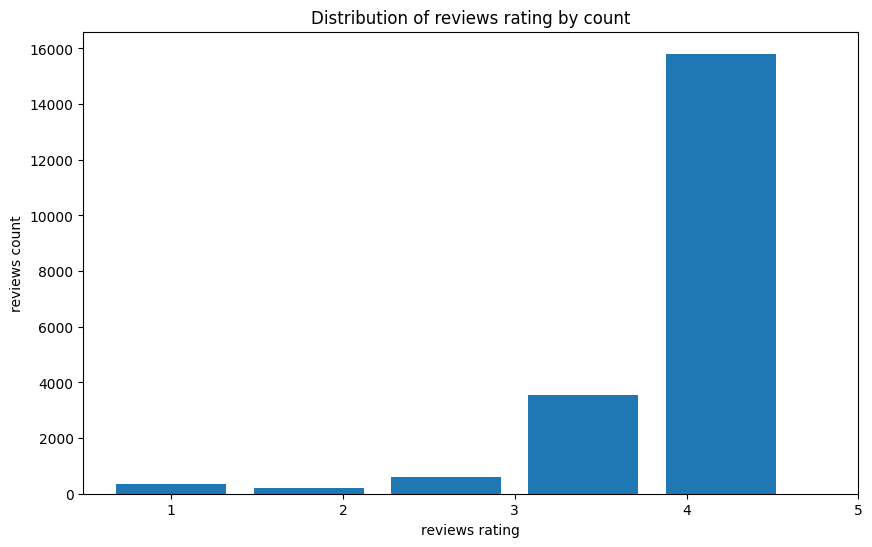

In [16]:
# check review_rating
plt.figure(figsize=(10, 6))  # Set the figure size
plt.title("Distribution of reviews rating by count")
plt.xlabel("reviews rating")
plt.ylabel("reviews count")

plt.hist(df['reviews_rating'], bins=5, align='left', rwidth=0.8)

plt.xticks(range(1, 6))  # Set the x-axis ticks to match the rating values (1 to 5)
plt.show()

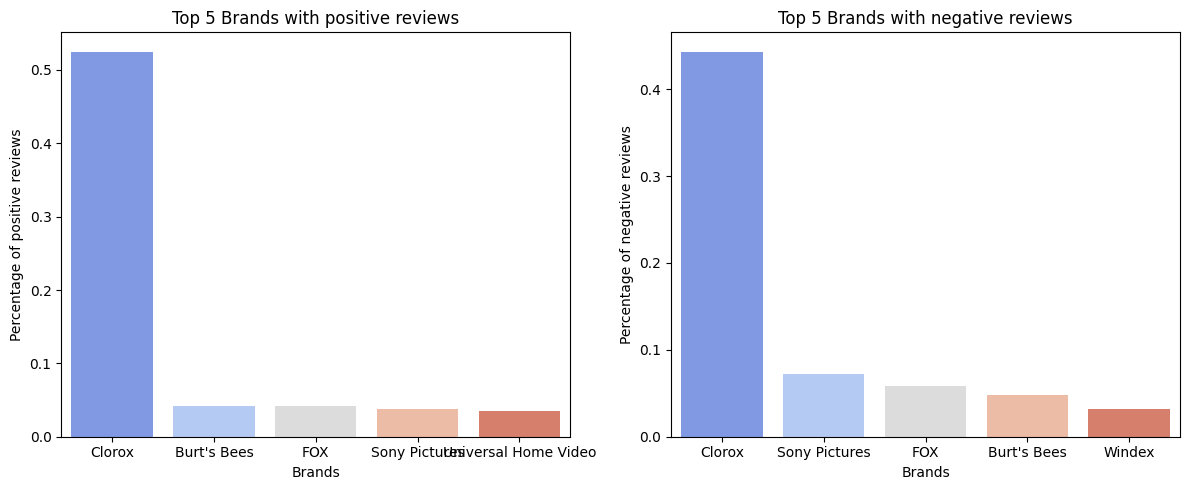

In [17]:
# checking brands for positive and negative reviews

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for positive reviews
positive_brands = df[df.user_sentiment == 'Positive'].brand.value_counts(normalize=True, ascending=False).head(5)
positive_plot = sns.barplot(x=positive_brands.index, y=positive_brands.values, palette='coolwarm', ax=axes[0])
positive_plot.set_title("Top 5 Brands with positive reviews")
positive_plot.set_xlabel("Brands")
positive_plot.set_ylabel("Percentage of positive reviews")

# Plot for negative reviews
negative_brands = df[df.user_sentiment == 'Negative'].brand.value_counts(normalize=True, ascending=False).head(5)
negative_plot = sns.barplot(x=negative_brands.index, y=negative_brands.values, palette='coolwarm', ax=axes[1])
negative_plot.set_title("Top 5 Brands with negative reviews")
negative_plot.set_xlabel("Brands")
negative_plot.set_ylabel("Percentage of negative reviews")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [18]:
df['reviews_date'] = pd.to_datetime(df['reviews_date'], errors='coerce')

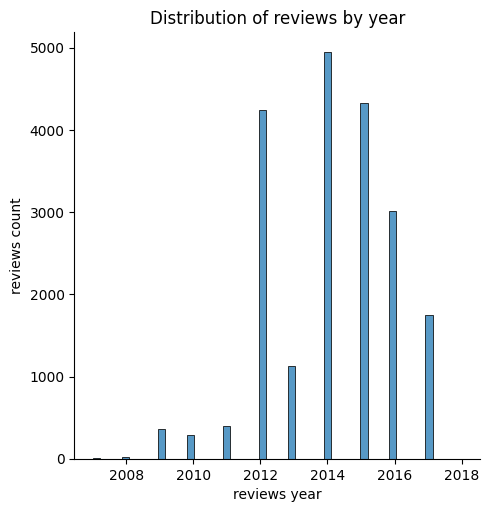

In [19]:
sns.displot(data=df, x=df.reviews_date.dt.year).set(title="Distribution of reviews by year", xlabel="reviews year", ylabel="reviews count")
plt.show()

In [20]:
# checking for count of negative reviews with more than 3 rating

filtered_data = df[(df.user_sentiment == 'Negative') & (df.reviews_rating >= 4)]
negative_counts = filtered_data['reviews_rating'].value_counts().sort_index()

In [21]:
# Type conversing columns to string

string_columns = ['brand', 'categories', 'manufacturer', 'name', 'reviews_text', 'reviews_title', 'reviews_username']
df[string_columns] = df[string_columns].applymap(str)


In [22]:
df.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,5.0,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5.0,Good flavor. This review was collected as part...,Good,dorothy w,Positive


Possibly we can combine review title and description for performing sentiment analysis over the text.

In [23]:
df = df.assign(reviews_combined=lambda x: x['reviews_text'] + " " + x['reviews_title']).drop(columns=['reviews_text', 'reviews_title'])

In [24]:
df.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_username,user_sentiment,reviews_combined
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,5.0,joshua,Positive,i love this album. it's very good. more to the...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5.0,dorothy w,Positive,Good flavor. This review was collected as part...


In [25]:
# dropping unwanted columns for building model

columns_to_drop = ['categories', 'manufacturer', 'reviews_date']
df = df.loc[:, ~df.columns.isin(columns_to_drop)]

In [26]:
df.head(2)

,id,brand,name,reviews_rating,reviews_username,user_sentiment,reviews_combined
0,AV13O1A8GV-KLJ3akUyj,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),5.0,joshua,Positive,i love this album. it's very good. more to the...
1,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5.0,dorothy w,Positive,Good flavor. This review was collected as part...


In [27]:
# Creating dataframe from features for sentiment analysis

df_senti = df.loc[:, ['id', 'name', 'reviews_combined', 'user_sentiment']].copy()

In [28]:
df_senti.head(1)

,id,name,reviews_combined,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive


In [29]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy

nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm")

def pre_process_text(text):
    # Convert text to lowercase and remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.lower().translate(translator)

    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words_no_stopwords = [word for word in words if word.lower() not in stop_words]

    # Lemmatize words
    lemmatized_words = [token.lemma_ for token in nlp(" ".join(words_no_stopwords))]

    cleaned_text = " ".join(lemmatized_words)

    return cleaned_text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [31]:
df_senti['reviews_pre_processed'] = df_senti['reviews_combined'].apply(pre_process_text)

In [32]:
df_senti = df_senti[['id','name','reviews_pre_processed', 'user_sentiment']]

## Feature Extraction

In [33]:
tfidf_params = {
    'min_df': 5,
    'max_df': 0.95,
    'stop_words': 'english',
    'ngram_range': (1, 2)
}

tfidf = TfidfVectorizer(**tfidf_params)

In [35]:
X = tfidf.fit_transform(df_senti['reviews_pre_processed'])

y= df_senti['user_sentiment']

## Train Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [37]:
print(f"Train shapes: {X_train.shape} {y_train.shape}")
print(f"Test shapes: {X_test.shape} {y_test.shape}")


Train shapes: (15375, 10421) (15375,)
Test shapes: (5126, 10421) (5126,)


In [38]:
# Handling imbalance using SMOTE for user_sentiment

print("Before handling imbalance", Counter(y_train))

# Oversampling using SMOTE
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)

print("After handling imbalance", Counter(y_train_sm))

Before handling imbalance Counter({'Positive': 13747, 'Negative': 1628})
After handling imbalance Counter({'Positive': 13747, 'Negative': 13747})


# Building Logistic Regression Model

In [39]:
# Display Evaluation scores

def evaluation_scores(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    conf_m = confusion_matrix(y_test, y_pred)

    print("Visualizing the Confusion Matrix with a Heatmap")
    print("\n")
    print("*" * 50)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(conf_m, annot=True, cbar=False, cmap="RdYlGn", fmt='d')
    plt.xlabel("Actual label")
    plt.ylabel("Predicted label")
    plt.show()
    print("*" * 50)
    print("\n")

    TP, TN, FP, FN = conf_m[1][1], conf_m[0][0], conf_m[0][1], conf_m[1][0]

    print("Values of True Positives, True Negatives, False Positivies and False Negatives")
    print("~" * 50)
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    print("~" * 50)
    print("\n")

    accuracy = round(accuracy_score(y_test, y_pred), 2)
    sensitivity_recall = round(TP / (TP + FN), 2)
    specificity = round(TN / (TN + FP), 2)
    precision = round(TP / (TP + FP), 2)
    F1_score = round(2 * (precision * sensitivity_recall) / (precision + sensitivity_recall), 2)

    print("Evaluation Score Summary")
    print('-' * 50)
    print(f'Accuracy Score: {accuracy}')
    print(f'Sensitivity/Recall Score: {sensitivity_recall}')
    print(f'Specificity Score: {specificity}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {F1_score}')
    print('-' * 50)

    evaluation_metrics = [accuracy, sensitivity_recall, specificity, precision, F1_score]
    return evaluation_metrics

Regression Model

In [40]:
logreg_params = {
    'random_state': 42,
    'solver': 'liblinear'
}

logreg = LogisticRegression(**logreg_params).fit(X_train_sm, y_train_sm)

Visualizing the Confusion Matrix with a Heatmap


**************************************************


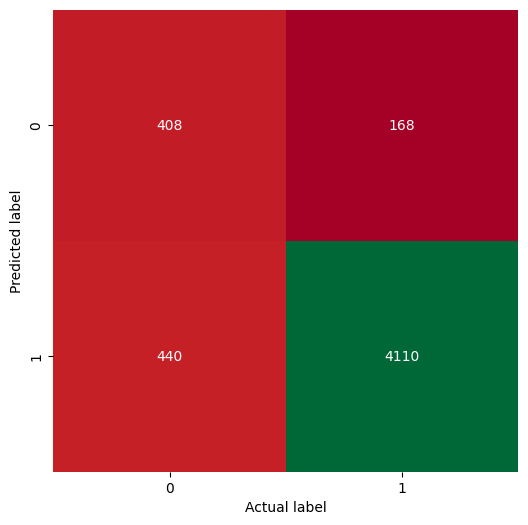

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 4110
True Negatives: 408
False Positives: 168
False Negatives: 440
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.88
Sensitivity/Recall Score: 0.9
Specificity Score: 0.71
Precision: 0.96
F1 Score: 0.93
--------------------------------------------------


In [41]:
# Getting the score of the base model
lr_metrics = evaluation_scores(logreg, X_test, y_test)

In [44]:
df_lrb_metrics = pd.DataFrame({
    'Metrics': ['Accuracy', 'Sensitivity/Recall', 'Specificity', 'Precision', 'F1 Score'],
    'Logistic Regression Base Model': lr_metrics
})
df_lrb_metrics

,Metrics,Logistic Regression Base Model
0,Accuracy,0.88
1,Sensitivity/Recall,0.90
2,Specificity,0.71
3,Precision,0.96
4,F1 Score,0.93
